<a href="https://colab.research.google.com/github/sakurasakura1996/Pytorch-start-learning/blob/master/Dive_into_DL_Pytorch_3_4_3_5_softmax%E5%9B%9E%E5%BD%92_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 这节将的是分类问题，softmax回归听起来可能是回归问题，而实际上却是分类问题
# softmax模型和线性回归一样将输入特征与权重做线性叠加。与线性回归的一个主要不同在于，softmax回归的输出值个数等于标签里的类别数。
# 损失函数还可以用平方损失函数，但是对于这种问题，平方损失可能太过于严格了。改善的方式就是使用更适合衡量两个概率分布差异的测量函数。
# 交叉熵（cross entropy)就是这样一个常用的衡量方法：他关心正确类别的预测概率，因为只要其足够大，就可以确保分类结果正确。

drive/  sample_data/


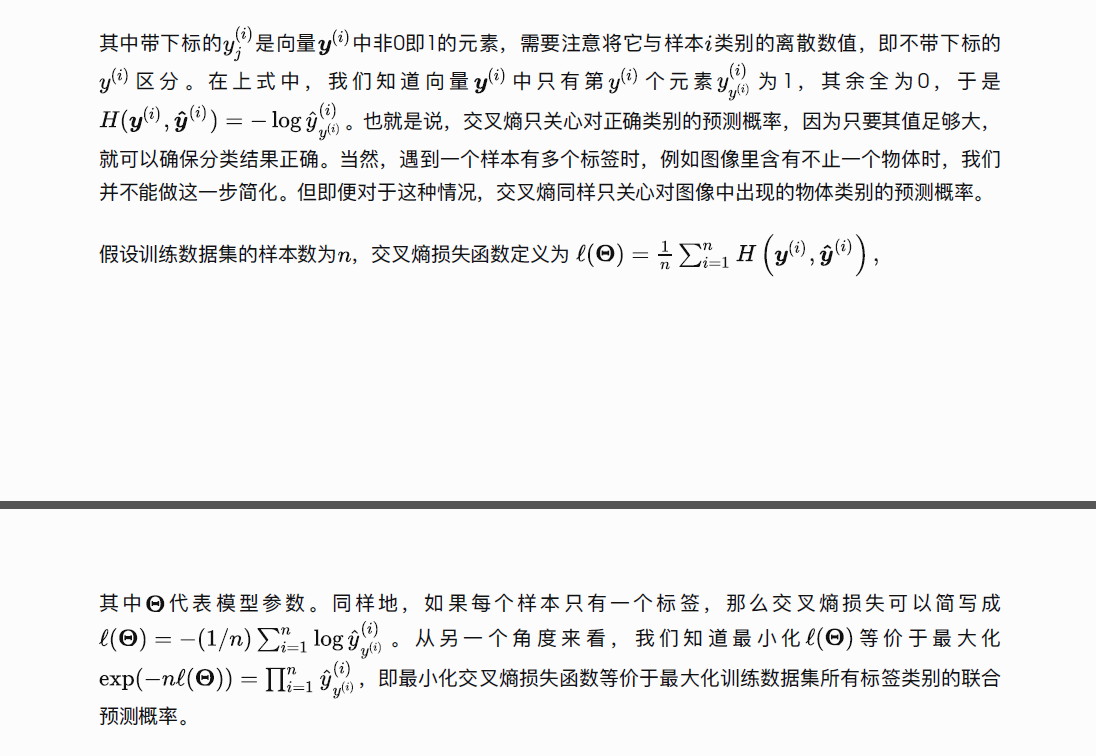

In [0]:
# 3.5 图像分类数据集（Fashion-Mnist)
# 在实现softmax回归前我们先引入一个多类图像分类数据集。大部分模型在mnist上的精度已经超过95%，这里引入的是fashion-mnist.本节将开始使用torchvision包
# torchvision是服务于pytorch深度学习框架的。主要用来构建计算机视觉模型。
# torchvision主要功能如下几部分：
# 1.torchvision.datasets:一些加载数据的函数及常用的数据集接口
# 2.torchvision.models:包含常用的模型结构（含预训练模型），例如AlexNet, VGG, ResNet等；这就简化了很多麻烦了
# 3.torchvision.transforms 常用的图片变换，  例如裁剪/旋转等
# 4.torchvison.utils 其他有用方法


In [3]:
# 3.5.1获取数据集
%matplotlib inline  
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
from IPython import display

# 我们将通过torchvision的torchvison.datasets来下载数据集。通过参数train来指定获取训练数据集或测试数据集
# 另外我们还指定参数 transform= transforms.ToTensor() 使所有数据转换为Tensor，如果不进行转换返回的是PIL图片。
# transforms.ToTensor() 将尺寸为H*W*C且数据值位于0~255的PIL图片或者数据类型为np.uint8的Numpy数组转换为尺寸为C*H*W且数据类型为torch.float32且位于0.0~1.0之间的Tensor
# 注意如果用像素值0~255表示图片数据，最好将数据类型设置为uint8
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=True,download=True,transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=False,download=True,transform=transforms.ToTensor())
# mnist_train mnist_test都是torch.utils.data.Dataset的子类，所以可以用len()来获取数据集大小，也可以用下标来获取样本


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [4]:
print(type(mnist_train))
print(len(mnist_train),len(mnist_test))

feature, label = mnist_train[0]
print(type(feature),type(label))
print(feature.size(), label)
print(feature.shape, label)    # torch.Size 也是一个Tensor
# 由于下载数据集时设置了 transforms.ToTensor() 所以将通道数放在最前面了，这是pytorch的格式

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000
<class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28]) 9
torch.Size([1, 28, 28]) 9


In [0]:
def get_fashion_mnist_labels(labels):
  """
  根据labels数值来返回它所代表的类别 str
  """
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress','coat','sandal', 'shirt', 'sneaker', 'bag', 'ankleboot']
  # return text_labels[labels] # 明显这个函数定义的太低级了吧。现在将输入改成labels ->一整个数据集的labels啊也就是一个列表
  return [text_labels[int(i)] for i in labels]

In [6]:
print(mnist_train[0][-1])

9


In [7]:

labels_train = mnist_train[0]
print(labels_train[-1])
# 妈的，真的到自己取出数据集中的最后一列label作为列表都取不出来，菜鸡啊
# 貌似这个mnist类不提供输入多维索引来提取元素。实在不行用循环来做，日

9


In [0]:
def use_svg_display():
  # 用矢量图显示
  display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
  use_svg_display()
  # 设置图的尺寸
  plt.rcParams['figure.figsize'] =  figsize

In [0]:
def show_fashion_mnist(images, labels):
  _, figs = plt.subplots(1, len(images), figsize=(15,15))
  for f, img, lbl in zip(figs, images, labels):
    f.imshow(img.view((28,28)).numpy())
    f.set_title(lbl)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
  plt.show()

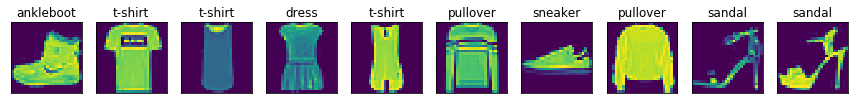

In [10]:
X, y = [], []
for i in range(10):
  X.append(mnist_train[i][0])
  y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [14]:
# 3.5.2读取小批量
# mnist_train 是 torch.utils.data.Dataset的子类，所以我们可以将其传入 torch.utils.data.DataLoader来创建一个读取小批量数据样本的DataLoader实例
import sys
batch_size = 256
print(sys.platform)
if sys.platform.startswith('win'):
  num_workers = 0
else:
  num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=num_workers)
# 该函数返回train_iter 和 test_iter两个变量，
# 查看一下读取一遍数据所需时间
start = time.time()
for X, y in train_iter:
  continue
print('%.2f sec' %(time.time() - start))

linux
5.24 sec
